In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy as sc 
import numpy as np
import cvxpy as cvx

import sys
import os
import importlib

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import covariance_functions.general_functions as gf
import covariance_functions.em_functions as em
import covariance_functions.ewma_functions as ewma
import covariance_functions.regularization_functions as reg
import covariance_functions.backtest_functions as bt


print(f"import start")
importlib.reload(gf)
importlib.reload(em)
importlib.reload(ewma)
importlib.reload(reg)
importlib.reload(bt)


from covariance_functions.em_functions import *
from covariance_functions.ewma_functions import *
from covariance_functions.ewma_functions import _ewma_cov
from covariance_functions.ewma_functions import iterated_ewma
from covariance_functions.general_functions import *
from covariance_functions.regularization_functions import *
from covariance_functions.backtest_functions import *

import warnings
warnings.filterwarnings("ignore")

import start
import end


# Import Data and Data Pre-Processing

In [2]:
returns = pd.read_csv('data/SP500_top25_adjusted.csv')
returns = returns.set_index('Unnamed: 0')
returns = returns.rename_axis('Date', axis='index')
returns.index = pd.to_datetime(returns.index, format='%Y-%m-%d')

FF = pd.read_csv('data/ff5.csv')
FF = FF.set_index('Unnamed: 0')
FF = FF.rename_axis('Date', axis='index')
FF.index = pd.to_datetime(FF.index, format='%Y-%m-%d')

rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

In [3]:
mapping_data=pd.read_csv('data/permno_to_ticker_mapping.csv')
mapping_df = pd.DataFrame(mapping_data)
returns.columns = returns.columns.astype(str)
permno_to_ticker = dict(zip(mapping_df['PERMNO'].astype(str), mapping_df['tic']))
returns.rename(columns=permno_to_ticker, inplace=True)

In [82]:
returns
csv_file_path = 'data/returns_data.csv'
returns.to_csv(csv_file_path)
csv_file_path



'data/returns_data.csv'

## Plot Cumulative Return of Sample Assets

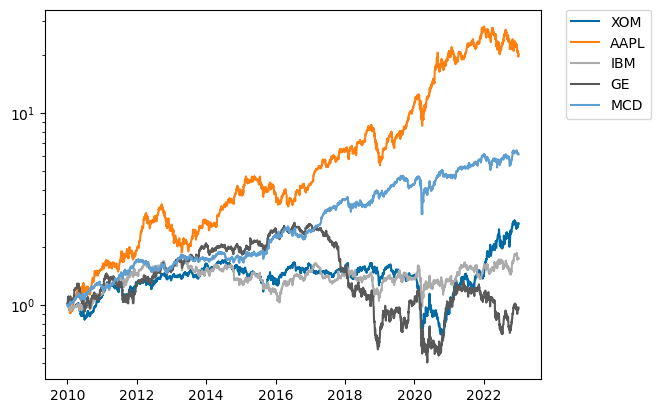

In [4]:
"""
https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
"""
plt.style.use('tableau-colorblind10')

columns = ["XOM", "AAPL", "IBM", "GE", "MCD"] #Original file had hwp, but can't find the PEMNOS so replaced with GE
plt.plot((returns[columns]+1).cumprod(axis=0), label=columns)
# fix legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale("log")

## Define Halflife Pairs
#### Specify the volatility halflife and covariance halflife for the EWMA

In [6]:
"""
rw_memory = rolling window size
    - reflect the number of trading days considered relevant.
    - 3 months = 60 days
    - 6 months = 125 days
    - 1 year = 250 days
ewma_halflife
iewma_pair = tuple (volatility halflife, covariance halflife) for a single iewma
cm_iewma_pairs = list of tuples of iewma_pairs
    - pairs are chosen to capture a variety of date ranges, from short term to 1 year
"""

rw_memory = 250
ewma_halflife=125
iewma_pair = (63,125)
cm_iewma_pairs = [(10, 21), (21, 63), (63, 125), (125, 250), (250, 500)]

## CM-IEWMA - Combined Multiple - Iterated Exponentially Weighted Moving Average


#### Start with IEWMA then combine it via SIGMA

In [23]:
# CM-IEWMA
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

# Regularize the first covariance matrix
for i in range(len(cm_iewma_pairs)):
    fast = cm_iewma_pairs[i]
    fast = f"{fast[0]}-{fast[1]}"
    Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results = list(from_sigmas(Sigmas, returns, means=None).solve(window=10))

Running iterated_ewma
Running iterated_ewma
Running iterated_ewma
Running iterated_ewma
Running iterated_ewma


In [24]:
cm_iewma = {result.time: result.covariance for result in results}
weights = {result.time: result.weights for result in results}


Text(0, 0.5, 'Cumulative Weight')

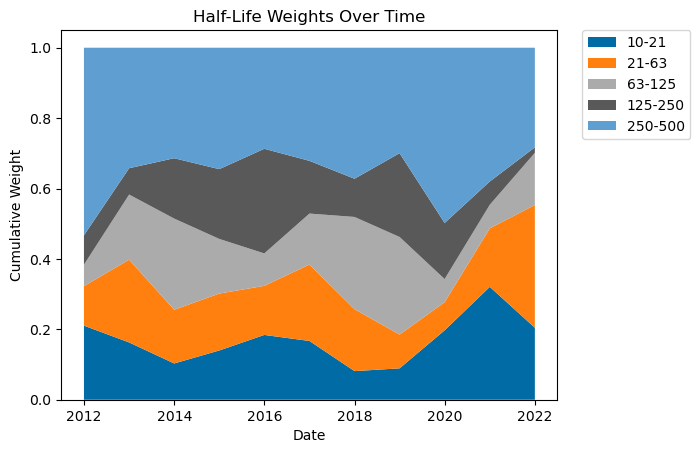

In [25]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("2011-12-28", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

quarterly_weights  = pd.DataFrame(weights).T.resample("YE").mean().loc[start_date:end_date]

plt.stackplot(quarterly_weights.index, quarterly_weights.values.T, labels=[f"{pair[0]}-{pair[1]}" for pair in cm_iewma_pairs])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Half-Life Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Weight')

Text(0, 0.5, 'Half-life (Days)')

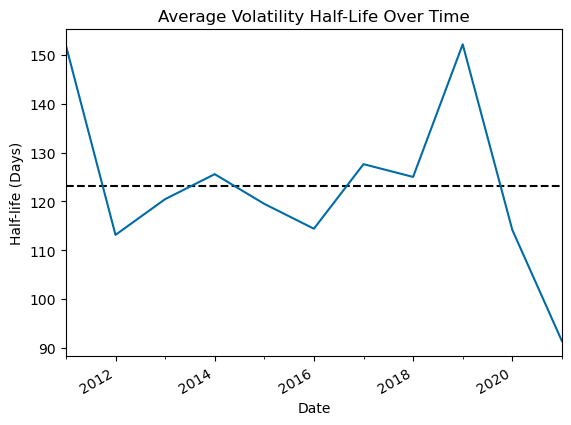

In [26]:
halflifes_vola = np.array([cm_iewma_pairs[i][0] for i in range(len(cm_iewma_pairs))])
(quarterly_weights * halflifes_vola).sum(axis=1).plot()
plt.axhline((quarterly_weights * halflifes_vola).sum(axis=1).mean(), color="black", linestyle="--", label="Mean half-life", zorder=-1)
plt.gcf().autofmt_xdate()
plt.title('Average Volatility Half-Life Over Time')
plt.xlabel('Date')
plt.ylabel('Half-life (Days)')

## Other Methods for Comparison


In [27]:
# general_functions: rolling_window 
rw = rolling_window(returns, rw_memory) 

# ewma_functions: ewma 
ewma = dict(_ewma_cov(returns, halflife=ewma_halflife))

#ewma_functions: iterated_ewma  
iewma = list(iterated_ewma(returns, vola_halflife=iewma_pair[0],cov_halflife=iewma_pair[1]))
iewma = {iterate.time: iterate.covariance for iterate in iewma}

# Prescient 
prescient = {}
for t in returns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, axis=0)
    prescient[t] = pd.DataFrame(cov+np.outer(mean, mean), index=returns.columns, columns=returns.columns)

Running iterated_ewma


## Backtests - MSE, Log-Likelihood, Regrets

In [38]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("1971-06-24", format="%Y-%m-%d")
# start_date = pd.to_datetime("2010-01-04", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

In [39]:
names = ["RW", "EWMA", "IEWMA", "CM-IEWMA", "Prescient"]

predictors_temp = [rw, ewma, iewma, cm_iewma, prescient]
predictors = []

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

### MSE Calculation
##### Compares each method's predicted covariance matrix against actual realized covariances useing the MSE metric for each method on a quarterly basis (RW, EWMA, IEWMA, MGARCH, CM-IEWMA, Prescient)

In [40]:
for i, predictior in enumerate(predictors):
    MSE_temp = MSE(returns, predictior).resample("QE").mean()

    print("\n" + names[i])
    print(f"mean: {MSE_temp.mean():.6f}")
    print(f"std: {MSE_temp.std():.6f}")
    print(f"max: {MSE_temp.max():.6f}")


RW
mean: 0.000313
std: 0.001511
max: 0.010913

EWMA
mean: 0.000307
std: 0.001497
max: 0.010813

IEWMA
mean: 0.000302
std: 0.001471
max: 0.010626

CM-IEWMA
mean: 0.000282
std: 0.001329
max: 0.009404

Prescient
mean: 0.000278
std: 0.001354
max: 0.009774


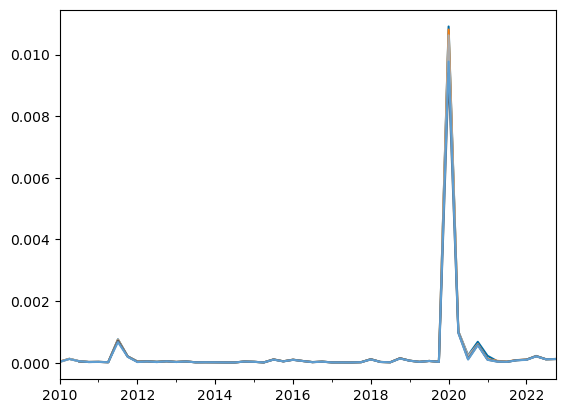

In [41]:
plt.figure()
for i, predictior in enumerate(predictors):
    MSE_temp = MSE(returns, predictior).resample("QE").mean()
    MSE_temp.plot()

### Log-Likelihood Calculation
##### Evaluate how well the covariance matrix fits the observed returns

In [42]:
names = ["RW", "IEWMA", "CM-IEWMA", "Prescient"]

predictors_temp = [rw, iewma, cm_iewma, prescient]
predictors = []

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

In [43]:
log_likelihoods = {}

for i, predictor in enumerate(predictors):
    print("Computing " + names[i] + " log-likelihood...")
    returns_temp = returns.loc[pd.Series(predictor).index].values[1:]
    times = pd.Series(predictor).index[1:]
    Sigmas_temp = np.stack([predictor[t].values for t in predictor.keys()])[:-1]

    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["Prescient"] - log_likelihoods[name]

Computing RW log-likelihood...


c:\Users\krupi\Development\MFE-230ZAB-Deep-Learning-and-Applications\covariance_functions\backtest_functions.py:53: RuntimeWarning: invalid value encountered in log
  - 1 / 2 * np.log(dets)


Computing IEWMA log-likelihood...
Computing CM-IEWMA log-likelihood...
Computing Prescient log-likelihood...


(50.0, 92.0)

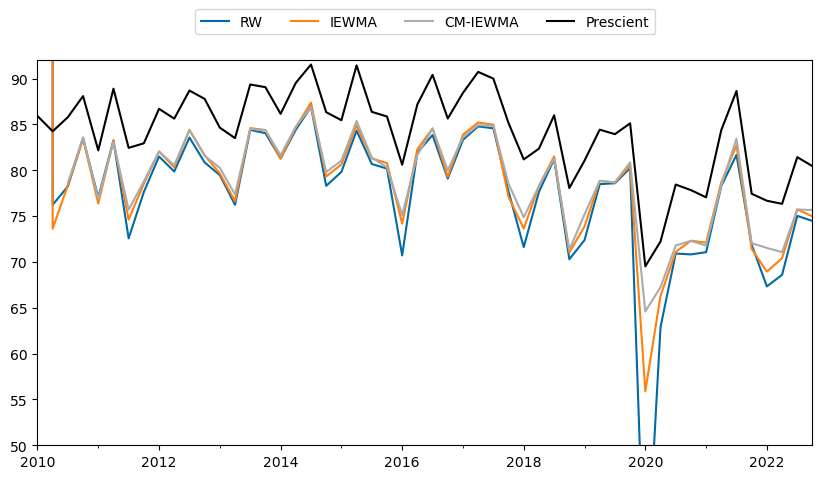

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'Prescient':
        log_likelihoods[name].resample("QE").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("QE").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5)
plt.ylim(50,92)